<a href="https://colab.research.google.com/github/SotaYoshida/Lecture_DataScience/blob/2021/notebooks/Python_misc_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 主成分分析

このノートブックでは主成分分析(principal component analysis, PCA)を説明する。  
基礎の理解に重点を置くため、scikit-learnなど既存のライブラリにあるPCA関数を利用するだけではなく、  
定式化とnumpyを用いた実装を行う。

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

## 主成分分析とは？

まず主成分分析とはなんだろうか？  

Wikipediaには
>相関のある多数の変数から相関のない少数で全体のばらつきを最もよく表す  
主成分と呼ばれる変数を合成する多変量解析の一手法

とある。

具体例を考えてみよう。  
ある集団200人の身長($x$)と体重($y$)のデータが下のように  
得られているとしよう。


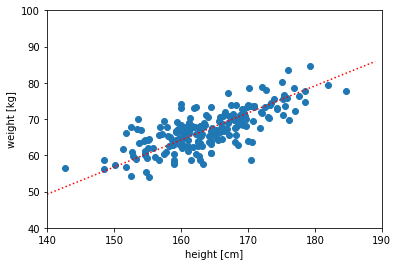

In [ ]:
mean = [165, 68]
mvec = [0,0]
cov=np.array([[1,0.8],[0.8,1.0]])
np.random.seed(1234)
x=[]; y=[]; n=200
for i in range(n):
    tx,ty = np.random.multivariate_normal(mvec,cov)
    x += [ mean[0] + 8*tx]
    y += [ mean[1] + 6*ty]
x=np.array(x);y=np.array(y)
xm = np.mean(x);ym = np.mean(y)
xp = np.arange(140,190,1); yp = np.corrcoef(x,y)[0,1] * (xp-xm) + ym

fig = plt.figure()
plt.xlim(140,190); plt.ylim(40,100)
plt.xlabel("height [cm]")
plt.ylabel("weight [kg]")
plt.scatter(x,y)
plt.plot(xp,yp,color="red",linestyle="dotted")
plt.show();plt.close()

上では"何らかの方法で"データの分布に沿った直線を描いてみた。  

この赤色の線を"体の大きさ"とでも呼ぶことにすると、  
元々は身長(x)と体重(y)の2つの量によってこの集団のデータを表現していたが、  
集団に属する個人をこの"体の大きさ"という1つの量で  
大雑把に指定(あるいは特徴づけ)できそうなことがわかる。

主成分分析は**高次元のデータを特徴づける少数の"軸方向"を見つけて  
その新たな軸に沿った値(主成分)でデータを表現し  
データを低次元空間で近似する方法**と言える。


人間が視覚的に理解できる情報は、3次元までである。  
一方でデータを分析していると、多次元(4~数十など)のデータを扱うことが度々あるが、  
主成分分析などを用いて特徴を抽出することで解釈がしやすくなったり、  
大量のデータがあったときその冗長性を削減することができる。

## PCAの定式化




主成分分析の大雑把なモチベーションがわかったところで  
上の軸方向/主成分の決め方を定式化しておこう。  

主成分を決める方針は主に、[主成分の分散を最大化する方針]と  
[情報量削減(主成分軸への距離の二乗和)の最小化]の2つがある。  
以下では、前者を採用することにしよう。


$p$次元の量を持つデータが$N$個観測されているとする→$\{ x_{ni}\} (n=1,...,N, i=1,....p)$  
このとき$p$個の各変数について、平均値を$\bar{x}_i = \frac{1}{N} \sum_{n=1}^N x_{ni} $で定義する。

このとき、$p$次元の成分それぞれの共分散を行列にもつ共分散行列${\bf C}$($p\times p$行列)は  
$
{\bf C}  = \frac{1}{N} \sum^N_{n=1,N} ({\bf x}_n - {\bf \bar{x}})\cdot ({\bf x}_n - {\bf \bar{x}})^T
$  
とかける。  

次に、各データを成分にもつ行列
$
{\bf X} = 
\begin{pmatrix}
x_{11} & x_{12} & ... & x_{1p} \\
x_{21} & x_{22} & ... & x_{2p} \\
\vdots & \vdots &\ddots & \vdots \\ 
x_{n1} & x_{n2} & ... & x_{np} 
\end{pmatrix}
$
と  
成分が1の$N$次元列ベクトル$1_N$で以下の($N\times p$)行列を定義する:  
$
\tilde{{\bf X}} = {\bf X} - 1_N  {\bf \bar{x}}^T
$

これを用いて、もとの共分散行列を書き換えると...
$ {\bf C}  = \frac{1}{N} \tilde{{\bf X}}^T \tilde{{\bf X}}$とかける。

次にデータ集合をある$p$次元の係数ベクトル${\bf u}$で$p$次元空間上に射影する:
$
{\bf s}_n = {\bf u}^T \cdot ( {\bf x}_n - {\bf \bar{x}})
$  
これを全データ点($n=1,2,...,N$)に対して行って$s_n$を縦に並べると$
{\bf S} = \tilde{{\bf X}} {\bf u}
$と書くことができる。



このとき、適当な係数ベクトル${\bf u}$のもとでの射影方向の分散は  
$\frac{1}{N}\sum^N_{i=1} |{\bf s}_i|^2 = \frac{1}{N} ({\bf u}^T\tilde{{\bf X}}^T) (\tilde{{\bf X}}{\bf u}) = {\bf u}^T {\bf C} {\bf u}
$
となる。

今考えたい問題は、この分散を最大化するような射影${\bf u}$を見つけることと言い換えられる。

加えて、以下ではそのような射影として${\bf u}^T \cdot {\bf u}=1$という条件を課すことにする。  
($p$次元空間での正規直交基底間の変換を探すことに対応)

そのためには$J({\bf u}) = {\bf u}^T {\bf C} {\bf u} - \lambda ({\bf u}^T\cdot {\bf u}-1)$の最大化を考えれば良い(ラグランジュ未定乗数法)  
$\frac{\partial J}{\partial {\bf u}} = 2 {\bf C} {\bf u} - 2\lambda{\bf u}=0 $から、今解きたい最適化問題は固有値問題:  
${\bf C} {\bf u}  = \lambda{\bf u}$に帰着されることがわかる。


この表式と上の分散の式から
$\frac{1}{N}\sum^N_{i=1} |{\bf s}_i|^2 = \lambda$となり  
**未定乗数$\lambda$がいま最大化したい分散に対応している**ことがわかる。 

最大固有値$\lambda_1$に属する固有ベクトルを第1主成分ベクトルと呼ぶ。  
第2主成分からは同様にして、第1主成分ベクトルと直行する固有ベクトルを考えれば  
分散を大きくする軸を順番に決定することができる。


また、$\frac{\lambda_i}{\sum^p_i \lambda_i}$を$i$番目の寄与率と呼び  
各主成分が元のデータに含まれる特徴をどの程度表現しているか  
あるいは幾つ主成分を保持しておけば元のデータに含まれる特徴を十分に表現(近似)できるのかの指標として用いられる。

## sklearnライブラリを使う方法

irisデータを使ってsklearnで主成分分析をやってみよう

In [ ]:
from sklearn import datasets
dataset = datasets.load_iris()
 
target_names = dataset.target_names
targets = dataset.target 
feature_names = dataset.feature_names
features = dataset.data

このデータには、3種類('setosa,versicolor,virginica)のアヤメについて  
がく片の長さ・幅と花弁の長さ・幅のデータが入っている。

In [ ]:
print(target_names)

['setosa' 'versicolor' 'virginica']


In [ ]:
import pandas as pd
from pandas import DataFrame
df = DataFrame(features, columns = feature_names)
df['target'] = target_names[targets]
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa



- がくの長さ/sepal length (cm)
- がくの幅/sepal width (cm)
- 花弁の長さ/petal length (cm)
- 花弁の幅/petal width (cm)

の4次元のデータで、可視化して理解することは難しい。  
そこで、このデータを3次元/2次元に落とし込んで理解することを目指す。

固有値 [4.22824171 0.24267075 0.0782095 ]
固有ベクトル [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]
 [-0.58202985  0.59791083  0.07623608  0.54583143]]


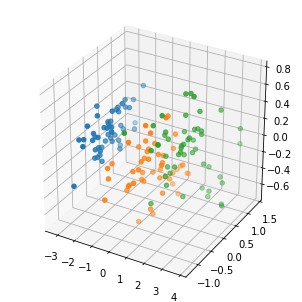

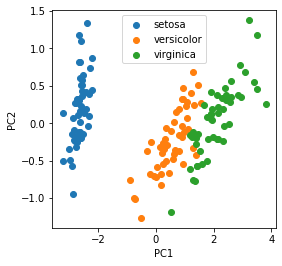

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

# PCA関数の使用 (3次元)
pca = PCA(n_components=3)
pca.fit(features)
res = pca.fit_transform(features)
print("固有値",pca.explained_variance_)
print("固有ベクトル",pca.components_)
#描画
fig = plt.figure(figsize = (4, 4))
ax = Axes3D(fig) 
for label in np.unique(targets):
    p = ax.scatter(res[targets == label, 0],
                   res[targets == label, 1],
                   res[targets == label, 2],
                   marker = 'o', s = 20)
plt.show()
plt.close()

# PCA関数の使用 (2次元)
pca = PCA(n_components=2)
pca.fit(features)
res = pca.fit_transform(features)

#描画
fig = plt.figure(figsize = (4, 4))
plt.xlabel("PC1"); plt.ylabel("PC2")
for label in np.unique(targets):
    plt.scatter(res[targets == label, 0],res[targets == label, 1],label=target_names[label])
plt.legend()
plt.show()
plt.close()

このように、４次元のデータを低次元に射影することで  
3種類のアヤメの持つ特徴を可視化できるようになる。

## 実装してみよう

sklearnなどのライブラリは非常に便利だが  
中で行われている計算がブラックボックスのため  
「本当に自身が意図した計算をやっているのか」が分かりづらい。

ライブラリを「使えれば良い」と「中身を分かった上で使う」の間には  
* 問題が起きたときの対処能力
* 自身で新規な手法を開発して実装する能力

などなど、様々な面で決定的な差が生じる。


以下では、必要な計算をなるべくブラックボックスにしないで  
PCAを実装してみよう。

In [ ]:
#上のコードと同様 irisデータを取得
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from sklearn import datasets
dataset = datasets.load_iris()
 
target_names = dataset.target_names
targets = dataset.target 
feature_names = dataset.feature_names
features = dataset.data

df = DataFrame(features, columns = feature_names) 
df.shape
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


今のデータは、上の定式化におけるN=150, p =4の場合に相当する事がわかる。

In [ ]:
N,p=df.shape
#データ行列の定義
X = df.values 

#p=1,2,3,4 各列の平均ベクトル(p×1行列)を定義
mv = np.array([ np.mean(X[:,i]) for i in range(p) ]).reshape(p,1) 

#共分散行列Cの計算
C = np.zeros((p,p)) # p×pのゼロ行列を作成
for i in range(N):
    d = X[i,:].reshape(p,1) - mv 
    C += np.dot(d,d.T) / N 

行列の固有値を求める部分の詳しい説明は、それだけでノートブックが複数必要なので  
Numpyの中にある固有値・固有ベクトルを計算する関数```np.linalg.eig```を用いる。

In [ ]:
vals,vecs = np.linalg.eig(C)
print("固有値",vals)
print("固有ベクトル",vecs.T) #固有ベクトルは縦に並んでいることに注意

固有値 [4.20005343 0.24105294 0.0776881  0.02367619]
固有ベクトル [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [-0.65658877 -0.73016143  0.17337266  0.07548102]
 [-0.58202985  0.59791083  0.07623608  0.54583143]
 [ 0.31548719 -0.3197231  -0.47983899  0.75365743]]


sklearnで計算された```explained_variance_```(固有値に対応)=```4.22824171, 0.24267075, 0.0782095```と  
わずかに値が異なっている。

実はsklearnでは不偏分散が使われているため、

In [ ]:
#共分散行列Cの計算 (不偏分散, sklearnと整合)
C = np.zeros((p,p)) # p×pのゼロ行列を作成
for i in range(N):
    d = X[i,:].reshape(p,1) - mv 
    C += np.dot(d,d.T) / (N-1) #分母 N → N-1
vals,vecs = np.linalg.eig(C)
print(vals)
print(vecs.T)

[4.22824171 0.24267075 0.0782095  0.02383509]
[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [-0.65658877 -0.73016143  0.17337266  0.07548102]
 [-0.58202985  0.59791083  0.07623608  0.54583143]
 [ 0.31548719 -0.3197231  -0.47983899  0.75365743]]


とすると、両者を整合させることができる。  
以降では、上の定式化を修正して不偏分散を用いることにしよう。

このように、ライブラリのソースコードを読むか自身で実装した関数と比較することで初めて  
「sklearnでは不偏分散が使われているんだな」ということが分かったりする。  

細かな実装が式と整合しているかどうかを確かめるのは重要で  
これを怠ると、再現性が損なわれたりバグの温床になる。  

余談:  
世の中でプログラムを書く人が全員「動けばいいや」の考えだと  
それがいつかサービスやシステムを通して社会(や自分自身)に大きな不利益をもたらすかもしれない。  
(たとえば自動運転の車による事故などを想像してみよう)

各データに対する第1主成分軸に沿った"得点"は、  
最大固有値に対応する固有ベクトル```vecs[:,0]```が  
射影になっていることを思い出すと、内積を取ればよい。  
```vecs[0]```とすると0番目の行ベクトルが取られて誤りになるので注意!

各点について第1主成分得点を計算してリストに詰めておこう

In [ ]:
PC1s = [ ]
for i in range(N):
    x = X[i,:].reshape(p,1) - mv 
    u = vecs[:,0].reshape(p,1)
    PC1 = np.dot(u.T,x)
    PC1s += [PC1]
    #print("i",i, "PC1",PC1)

同様にして

In [ ]:
PC2s = [ ] 
for i in range(N):
    x = X[i,:].reshape(p,1) - mv 
    u = vecs[:,1].reshape(p,1)
    PC2 = np.dot(u.T,x)
    PC2s += [ PC2 ]

プロットしてみよう

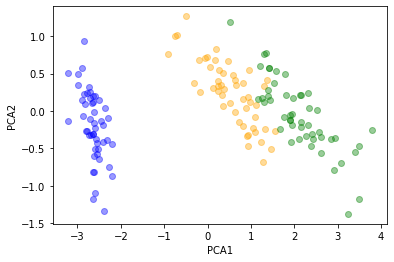

In [ ]:
cols = ["blue","orange","green"]

fig = plt.figure(figsize = (6, 4))
plt.xlabel("PC1"); plt.ylabel("PC2")
for i in range(N):
    x = PC1s[i]
    y = PC2s[i]
    plt.scatter(x,y,color=cols[targets[i]],alpha=0.4)
plt.show()
plt.close()

sklearnの出力と上下がひっくり返っている。  
yにマイナスをかけて向きをあわせてみると...

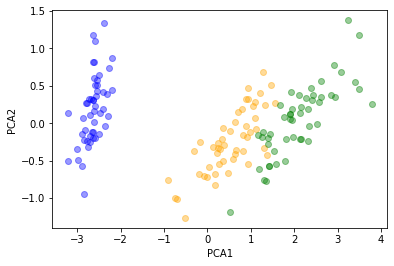

In [ ]:
fig = plt.figure(figsize = (6, 4))
plt.xlabel("PC1"); plt.ylabel("PC2")
for i in range(N):
    x = PC1s[i]
    y = PC2s[i]
    plt.scatter(x,-y,color=cols[targets[i]],alpha=0.4)
plt.show()
plt.close()

sklearnと同じ結果を与える自作コードを作ることが出来ました。

上の符号反転について:

第2主成分に対応する固有ベクトルは、sklearnと自前関数で得られた値で符号が異なっている。  
今のように、分散を大きくする軸を見つける場合、  
当然軸の反転(固有ベクトル全体の符号)の自由度が残されている。    
実装によって符号が異なるのは、固有値問題を解く際に使用されているソルバー
におけるconventionの違いなどに由来している。

# $\clubsuit$ オートエンコーダ(自己符号化器)




編集予定

#LICENSE


Copyright (C) 2021 Sota Yoshida

[ライセンス:クリエイティブ・コモンズ 4.0 表示 (CC-BY 4.0)](https://creativecommons.org/licenses/by/4.0/deed.ja)